# Simple example for how to load and plot ice data

This script shows how to load and plot sea ice concentration from CICE output, while also indicating how to get around some of the pitfalls and foibles in CICE temporal and spatial gridding.

Requirements: The conda/analysis3 (or later) module on ARE. 

Firstly, load modules:

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
from dask.distributed import Client
from datetime import timedelta
import cf_xarray as cfxr
import cartopy.crs as ccrs

If we want, we can start a client - not strictly necessary for this small case but could help for longer timeseries:

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 15.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35031,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 15.00 GiB
Comm: tcp://127.0.0.1:40519,Total threads: 1
Dashboard: /proxy/34209/status,Memory: 3.75 GiB
Nanny: tcp://127.0.0.1:35693,


Start a database session:

In [3]:
session = cc.database.create_session()

Load sea ice area (`aice_m`) from the Repeat-Year forcing experiment. (We could, alternatively, try to load ice thickness (`hi_m`) or ice volume (`vicen_m`).) Note that we are just loading the last 10 years here.

Note also the `decode_coords=False` flag. **This gets around some messy issues with the way xarray decides to load CICE grids**:

In [4]:
sic_args = {
    "expt": "01deg_jra55v13_ryf9091",
    "variable": "aice_m",
    "start_time": "2090-02-01",
    "decode_coords":False
}

var = cc.querying.getvar(
    session=session, 
    **sic_args
)

**Another messy thing about CICE is that it thinks that monthly data for, say, January occurs at midnight on Jan 31 -- while xarray interprets this as the first milllisecond of February.**  
  
To get around this, note that we loaded data from February above, and we now subtract 12 hours from the time dimension. This means that, at least data is sitting in the correct month, and really helps to compute monthly climatologies correctly.

In [5]:
var['time'] = var.time.to_pandas() - timedelta(hours = 12)

Note that `aice_m` is the monthly average of fractional ice area in each grid cell aka the concentration. **To find the actual area of the ice we need to know the area of each cell. Unfortunately, CICE doesn't save this for us ... but the ocean model does.** So, let's load `area_t` from the ocean model, and rename the coordinates in our ice variable to match the ocean model. Then we can multiply the ice concentration with the cell area to get a total ice area.

In [6]:
area_t = cc.querying.getvar(sic_args['expt'], 'area_t',session,n = 1)

We are only interested in the 2D grid for CICE, so we can drop geolon and geolat

In [7]:
area_t=area_t.drop_vars(['geolon_t', 'geolat_t'])

We are going to use area_t to assign values to the x and y coordinates from the CICE data

In [8]:
var.coords['ni'] = area_t['xt_ocean'].values
var.coords['nj'] = area_t['yt_ocean'].values

So that our new coordinates are recognised as cf standard, we also need to copy the attributes. This notebook is designed to use `cf-xarray`. This means the rest of the notebook is [Model Agnostic](https://cosima-recipes.readthedocs.io/en/latest/Tutorials/Model_Agnostic_Analysis.html).

In [9]:
var.ni.attrs=area_t.xt_ocean.attrs
var.nj.attrs=area_t.yt_ocean.attrs

In [10]:
var = var.rename(({'ni':'xt_ocean', 'nj':'yt_ocean'}))

Check that we have CF axes

In [11]:
var.cf

Coordinates:
             CF Axes: * X: ['xt_ocean']
                      * Y: ['yt_ocean']
                        Z, T: n/a

      CF Coordinates: * longitude: ['xt_ocean']
                      * latitude: ['yt_ocean']
                        vertical, time: n/a

       Cell Measures:   area, volume: n/a

      Standard Names:   n/a

              Bounds:   n/a

       Grid Mappings:   n/a

Now that we have axes with cf compliant coordinates, we can select using `latitude` keywords.

Let's look at a timeseries of SH sea ice area. Area is defined (per convention) as the sum of sea ice concentration multiply by the area of each grid cell (and masked for sea ice concentration above 15%)

In [12]:
var=var.where(var>=0.15).cf.sel(latitude=slice(-90,-45))

SH_area=(var*area_t).cf.sum(['latitude','longitude'])

2023-09-04 16:36:37,384 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.61 GiB -- Worker memory limit: 3.75 GiB
2023-09-04 16:36:41,094 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 2.61 GiB -- Worker memory limit: 3.75 GiB
2023-09-04 16:36:41,371 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- U

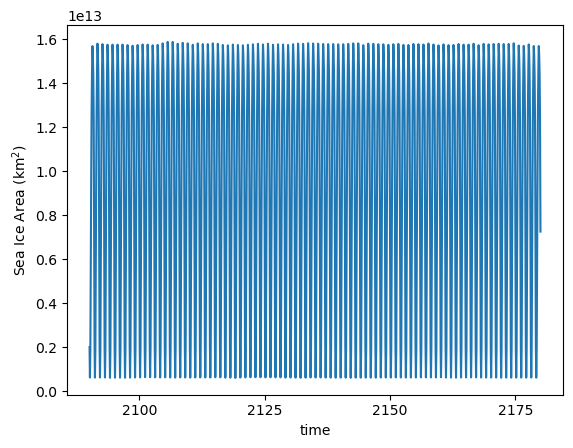

In [13]:
SH_area.plot()
_=plt.ylabel('Sea Ice Area (km$^{2}$)')

Or, we can look at the seasonal cycle of SH ice concentration.

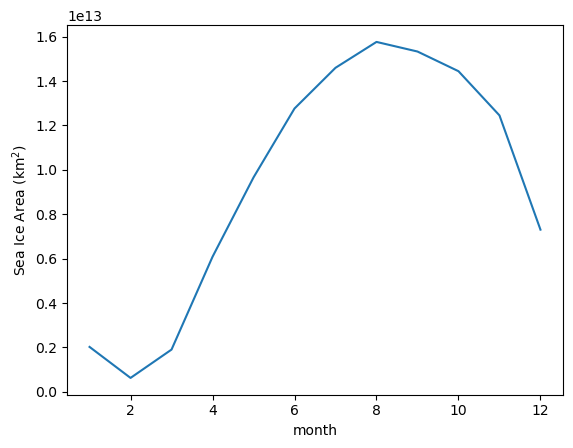

In [14]:
SH_area.groupby('time.month').mean('time').plot()
_=plt.ylabel('Sea Ice Area (km$^{2}$)')

We can plot a map of sea ice concentration for a selected month, as follows:

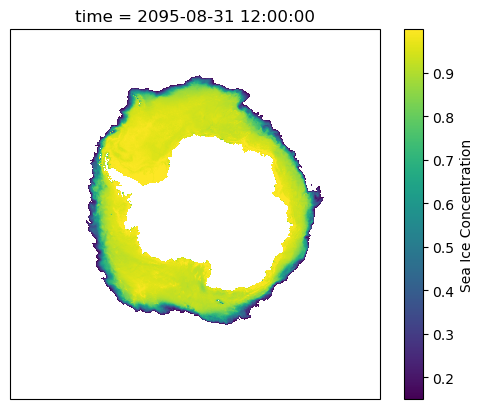

In [15]:
def plot_sh_si_conc():
    plt.subplot(projection=ccrs.SouthPolarStereo())
    var.sel(time='2095-08-31').plot(
        transform=ccrs.PlateCarree(),
        cbar_kwargs={
            'label':'Sea Ice Concentration'
        }
    )

plot_sh_si_conc()

Once we are happy with your plot, we can save the plot to disk using `plt.savefig('filepath/filename')` function at the end of the cell containing the plot we want to save, as shown below. Note that your filename must contain the file (e.g., pdf, jpeg, png, etc.).  
For more information on the options available to save figures refer to [https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html].

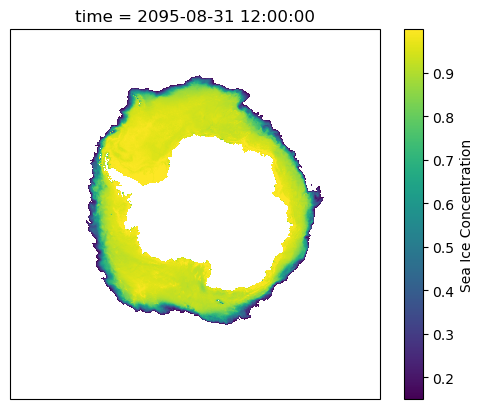

In [16]:
plot_sh_si_conc()
plt.savefig('MyFirstPlot.png', dpi = 300)